## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [15]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt
import IPython
import sys, os, array, time
import serial 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


**QUESTION:** Load dataset and display some lines of the csv file.

In [16]:
Raw_data = pd.read_excel('./ai4i2020.xlsx')
print(Raw_data.iloc[0])
print("---")
print(Raw_data.iloc[150])
print("---")


UDI                             1
Product ID                 M14860
Type                            M
Air temperature [K]         298.1
Process temperature [K]     308.6
Rotational speed [rpm]       1551
Torque [Nm]                  42.8
Tool wear [min]                 0
Machine failure                 0
TWF                             0
HDF                             0
PWF                             0
OSF                             0
RNF                             0
Name: 0, dtype: object
---
UDI                           151
Product ID                 L47330
Type                            L
Air temperature [K]         298.4
Process temperature [K]     308.3
Rotational speed [rpm]       1422
Torque [Nm]                  42.7
Tool wear [min]               186
Machine failure                 0
TWF                             0
HDF                             0
PWF                             0
OSF                             0
RNF                             0
Name: 150, dtype: obj

**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

Machine failure
0    9661
1     339
Name: count, dtype: int64


Text(0.5, 1.0, 'failed and functionnal machines')

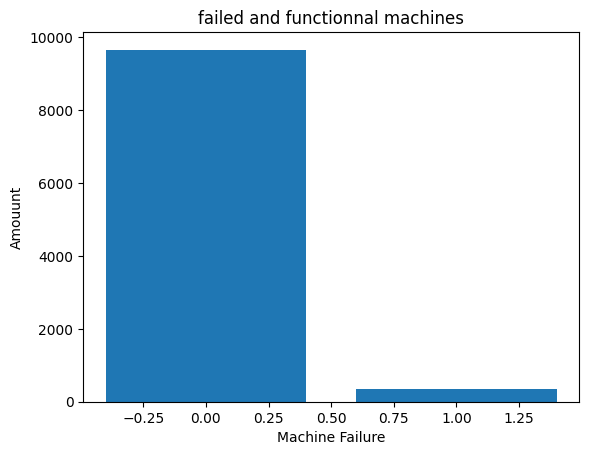

In [17]:
compte = Raw_data["Machine failure"].value_counts()
print(compte)
plt.bar(compte.index, compte.values)
plt.xlabel('Machine Failure')
plt.ylabel('Amouunt')
plt.title('failed and functionnal machines')


**ANALYSIS QUESTION:** What do you observe?

Much more working machine than dysfunctional ones.

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

"Write here your response"

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

Text(0.5, 1.0, 'Amount of failure types')

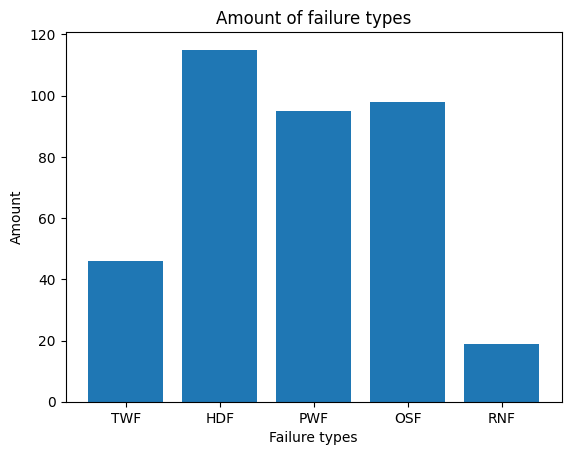

In [18]:
plt.bar(['TWF','HDF','PWF','OSF','RNF'],[Raw_data['TWF'].sum(),Raw_data['HDF'].sum(),Raw_data['PWF'].sum(),Raw_data['OSF'].sum(),Raw_data['RNF'].sum()])
plt.xlabel('Failure types')
plt.ylabel('Amount')
plt.title('Amount of failure types')

**ANALYSIS QUESTION:** What do you observe?

There are 3 principal failure types (HDF, PWF, OSF) and 3 less frequent failures (TWF, RNF)

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

Number of 'No Specific Failure' cases: 9


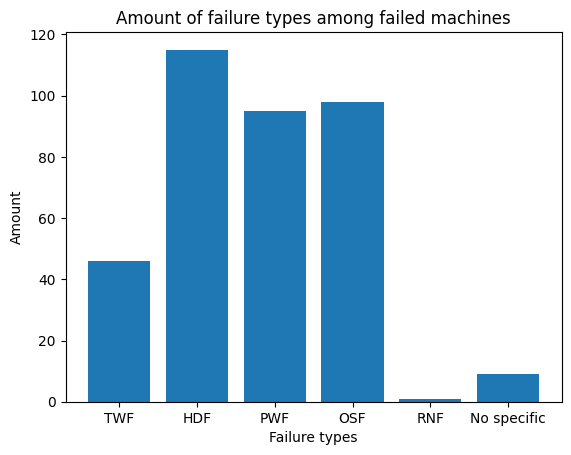

In [19]:
colonne_cible = 'Machine failure'
condition = (Raw_data[colonne_cible] == 1) & (Raw_data['TWF'] == 0) & (Raw_data['HDF'] == 0) & (Raw_data['PWF'] == 0) & (Raw_data['OSF'] == 0) & (Raw_data['RNF'] == 0)
count_no_specific = Raw_data[condition].shape[0]

failure_data = Raw_data[Raw_data[colonne_cible] == 1]

plt.bar(['TWF','HDF','PWF','OSF','RNF','No specific'], 
    [failure_data['TWF'].sum(), failure_data['HDF'].sum(), failure_data['PWF'].sum(), 
     failure_data['OSF'].sum(), failure_data['RNF'].sum(), count_no_specific])
plt.xlabel('Failure types')
plt.ylabel('Amount')
plt.title('Amount of failure types among failed machines')

print(f"Number of 'No Specific Failure' cases: {count_no_specific}")

**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

"Write your response here"

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [20]:
print(Raw_data.dtypes)

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object


**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to jsurtify your response.

"Write your response here"

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [21]:
Raw_data["Functionnal"] = 1-Raw_data['Machine failure']
data_df = Raw_data.drop(['Type','UDI','Product ID','RNF', 'Machine failure'], axis=1)
print(data_df.iloc[0])
print("---")
data_inputs = data_df.iloc[:,0:5]
print(data_inputs.iloc[0])
print("---")
data_outputs = data_df.iloc[:,5:]
print(data_outputs.iloc[0])
X_train, X_test, Y_train, Y_test = train_test_split(data_inputs, data_outputs, test_size=0.3, random_state=42)
X_test,X_valid,Y_test,Y_valid = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)
output_labels = data_outputs.columns.tolist()
print(output_labels)

Air temperature [K]         298.1
Process temperature [K]     308.6
Rotational speed [rpm]     1551.0
Torque [Nm]                  42.8
Tool wear [min]               0.0
TWF                           0.0
HDF                           0.0
PWF                           0.0
OSF                           0.0
Functionnal                   1.0
Name: 0, dtype: float64
---
Air temperature [K]         298.1
Process temperature [K]     308.6
Rotational speed [rpm]     1551.0
Torque [Nm]                  42.8
Tool wear [min]               0.0
Name: 0, dtype: float64
---
TWF            0
HDF            0
PWF            0
OSF            0
Functionnal    1
Name: 0, dtype: int64
['TWF', 'HDF', 'PWF', 'OSF', 'Functionnal']


**QUESTION** Code below the model architecture

In [22]:
X_test,X_valid,Y_test,Y_valid = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)
inputs = Input(shape=(5,))  

x = Dense(1024, kernel_regularizer=l2(0.001))(inputs)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.25)(x)

x = Dense(512, kernel_regularizer=l2(0.001))(inputs)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.25)(x)


x = Dense(256, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.25)(x)


x = Dense(128, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.25)(x)


x = Dense(64, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.25)(x)


x = Dense(32, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.25)(x)


outputs = Dense(5, activation='softmax')(x)

unbalanced = tf.keras.Model(inputs=inputs, outputs=outputs, name="unbalanced")

unbalanced.summary()

unbalanced.compile(optimizer=Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

nb_epochs = 50
batch_size = 120

training_history = unbalanced.fit(X_train, Y_train,validation_data=(X_valid, Y_valid),epochs=nb_epochs,batch_size=batch_size)


Model: "unbalanced"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_16 (ReLU)                 │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_17 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 181,765 (710.02 KB)

 Trainable params: 179,781 (702.27 KB)

 Non-trainable params: 1,984 (7.75 KB)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.4773 - loss: 2.0206 - val_accuracy: 0.0067 - val_loss: 5.2521
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6005 - loss: 1.8579 - val_accuracy: 0.0160 - val_loss: 3.5760
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6818 - loss: 1.7277 - val_accuracy: 0.0853 - val_loss: 2.6632
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7542 - loss: 1.6170 - val_accuracy: 0.7267 - val_loss: 2.0032
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8070 - loss: 1.5244 - val_accuracy: 0.9120 - val_loss: 1.6233
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8534 - loss: 1.4088 - val_accuracy: 0.9413 - val_loss: 1.4589
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8853 - loss: 1.3355 - val_accuracy: 0.9520 - val_loss: 1.3564
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9010 - loss: 1.2757 - val_accuracy: 0.9693 - v

**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

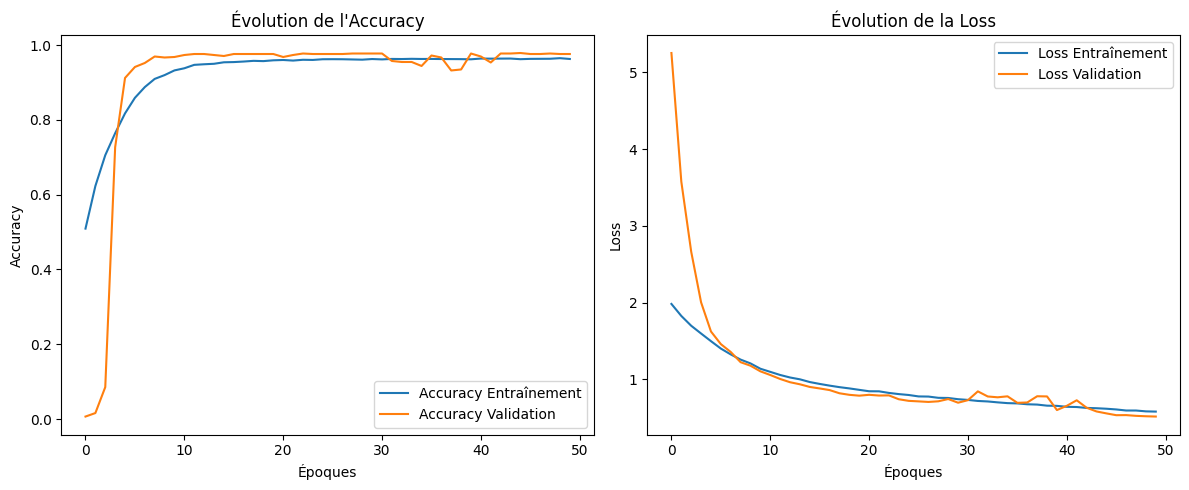

In [23]:
import matplotlib.pyplot as plt

# Tracer l'Accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(training_history.history['accuracy'], label='Accuracy Entraînement')
plt.plot(training_history.history['val_accuracy'], label='Accuracy Validation')
plt.title('Évolution de l\'Accuracy')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.legend()

# Tracer la Loss
plt.subplot(1,2,2)
plt.plot(training_history.history['loss'], label='Loss Entraînement')
plt.plot(training_history.history['val_loss'], label='Loss Validation')
plt.title('Évolution de la Loss')
plt.xlabel('Époques')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

"Write your response here"

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

**QUESTION** Code below the algorithms allowing to train model


**QUESTION** Plot the confusion matrix and the classification report

**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"